In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report,explained_variance_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [10]:
# loading datasets and preliminary cleaning
rotten=pd.read_csv('../../data/rotten_tomatoes_movies.csv')
rotten=rotten.drop(['rotten_tomatoes_link', 'content_rating', 'actors', 'streaming_release_date', 
                    'movie_info', 'critics_consensus', 'genres', 'directors', 'authors',# 'original_release_date',  
                    'production_company', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count'], axis=1)


imdb=pd.read_csv('../../data/movies_meta.csv')
imdb=imdb.loc[imdb['original_language']=='en']  # only english movies
imdb=imdb.drop(['production_countries', 'overview', 'tagline', 'belongs_to_collection', 'homepage', 'revenue', 'spoken_languages', 'video', 'homepage', "poster_path", 'production_companies'], axis=1)
print(len(imdb))

3608


In [11]:
print(rotten)

                                             movie_title  \
0      Percy Jackson & the Olympians: The Lightning T...   
1                                            Please Give   
2                                                     10   
3                        12 Angry Men (Twelve Angry Men)   
4                           20,000 Leagues Under The Sea   
...                                                  ...   
17707                                          Zoot Suit   
17708                                           Zootopia   
17709                                    Zorba the Greek   
17710                                               Zulu   
17711                                          Zulu Dawn   

      original_release_date  runtime tomatometer_status  tomatometer_rating  \
0                2010-02-12    119.0             Rotten                49.0   
1                2010-04-30     90.0    Certified-Fresh                87.0   
2                1979-10-05    122.0      

### Preprocessing the datasets

In [12]:
# one hot encoder for genres
genres=['Action',  'History', 'Adventure',  'Horror', 'Adult',  'Music', 'Animation',  'Musical', 'Biography',  'Mystery', 'Comedy',  'Romance', 
'Crime',   'Sci-Fi', 'Documentary',  'Short', 'Drama',  'Sport',  'Family',  'Thriller', 'Fantasy',  'Film-noir',    
'History',  'Horror', 'Music', 'Mystery', 'Romance',  'Short',  'War', 'Western', 'Science Fiction']

for i in genres:
    imdb[i]=0

for idx, row in enumerate(imdb['genres'][:20]):
    imdb[row.split("'")[5]][idx]=1
    try:
        imdb[row.split("'")[11]][idx]=1
    except IndexError:
        pass
    try:
        imdb[row.split("'")[17]][idx]=1
    except IndexError:
        pass
    
print(imdb)

/tmp/ipykernel_146/2593257763.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb[row.split("'")[5]][idx]=1
/tmp/ipykernel_146/2593257763.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb[row.split("'")[11]][idx]=1
/tmp/ipykernel_146/2593257763.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb[row.split("'")[17]][idx]=1


      adult    budget                                             genres  \
0     False  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1     False  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2     False  58000000  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...   
3     False   3600000  [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...   
4     False  29500000  [{'id': 878, 'name': 'Science Fiction'}, {'id'...   
...     ...       ...                                                ...   
4684  False         0                      [{'id': 18, 'name': 'Drama'}]   
4685  False         0  [{'id': 878, 'name': 'Science Fiction'}, {'id'...   
4687  False  30000000  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   
4688  False         0  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4689  False         0                                                 []   

          id    imdb_id original_language                  original_title  \
0        8

/tmp/ipykernel_146/2593257763.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb[row.split("'")[11]][idx]=1
/tmp/ipykernel_146/2593257763.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb[row.split("'")[17]][idx]=1
/tmp/ipykernel_146/2593257763.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb[row.split("'")[5]][idx]=1
/tmp/ipykernel_146/2593257763.py:12: SettingWithCopyWarning: 
A value is trying to be set on a 

0       7.7
1       6.9
2       6.6
3       7.1
4       7.4
       ... 
4684    0.0
4685    7.3
4687    6.1
4688    4.6
4689    0.0
Name: vote_average, Length: 3608, dtype: float64


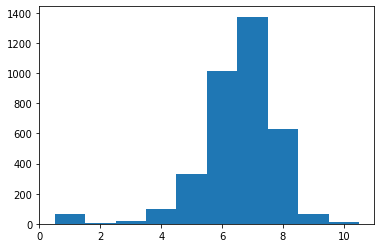

3    1850
2    1493
1     144
0      68
4      53
Name: vote_class, dtype: int64


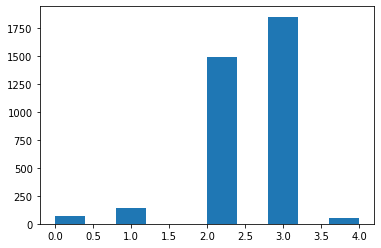

In [13]:
# split votes in 5 categories
print(imdb['vote_average'])
imdb['vote_average']=imdb['vote_average'].apply(lambda x: x+0.5)


plt.hist(imdb["vote_average"])
plt.show()
imdb['vote_class']=pd.cut(imdb["vote_average"], bins=5, labels=[0, 1, 2, 3, 4])
plt.hist(imdb["vote_class"])
print(imdb['vote_class'].value_counts())

In [14]:

def clean_title(x):
    '''
    Method to normalize the movie titles
    '''
    for char in [",", "'", ".", ":", ";", "(", ")", "/", "!", "?", "%", "-", "_", "="]:
        x=x.replace(char, "")        
    return x.lower()


def drama(df):
    '''
    Method that returns subset containing all drama movies
    '''
    drama=[]
    df=df.reset_index()
    for row in df['genres']:
        if "Drama" in row:
            drama.append(True)
        else:
            drama.append(False)   
    df=df.drop('index', axis=1)
    df['drama']=pd.Series(drama)
    return df.loc[df['drama']==True]
    
def after_date(df, year):
    '''
    Method that returns subset with only movies from year 
    '''
    return imdb.loc[imdb['release_date']> year+'-01-01']



 
rotten['movie_title']=rotten['movie_title'].apply(clean_title)
imdb['title']=imdb['title'].apply(clean_title)

### Combining the imdb and rotten tomatoes datasets

In [15]:
# combine rotten and imdb data

def combine(df1, df2):
    result = pd.merge(df1, df2, how="inner", left_on='movie_title', right_on='title')
    result = result.drop(['movie_title'], axis=1)
    return result

combined=combine(rotten, imdb)
print(combined.columns)
print("movies in rotten data: ", rotten.__len__())
print("movies in imdb data: ", imdb.__len__())
print("movies in overlap: ", combined.__len__())

Index(['original_release_date', 'runtime_x', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_status',
       'audience_rating', 'audience_count', 'tomatometer_top_critics_count',
       'adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'release_date', 'runtime_y', 'status',
       'title', 'vote_average', 'vote_count', 'Action', 'History', 'Adventure',
       'Horror', 'Adult', 'Music', 'Animation', 'Musical', 'Biography',
       'Mystery', 'Comedy', 'Romance', 'Crime', 'Sci-Fi', 'Documentary',
       'Short', 'Drama', 'Sport', 'Family', 'Thriller', 'Fantasy', 'Film-noir',
       'War', 'Western', 'Science Fiction', 'vote_class'],
      dtype='object')
movies in rotten data:  17712
movies in imdb data:  3608
movies in overlap:  2553


In [16]:
print(rotten['tomatometer_status'].value_counts())
print(combined['genres']) ### extract genres

Rotten             7565
Fresh              6844
Certified-Fresh    3259
Name: tomatometer_status, dtype: int64
0                         [{'id': 37, 'name': 'Western'}]
1                         [{'id': 37, 'name': 'Western'}]
2                           [{'id': 18, 'name': 'Drama'}]
3       [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
4       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
                              ...                        
2548    [{'id': 10751, 'name': 'Family'}, {'id': 14, '...
2549    [{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...
2550    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
2551    [{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...
2552    [{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...
Name: genres, Length: 2553, dtype: object


In [10]:
print(combined.columns)
print(combined.__len__())

Index(['original_release_date', 'runtime_x', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_status',
       'audience_rating', 'audience_count', 'tomatometer_top_critics_count',
       'adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'release_date', 'runtime_y', 'status',
       'title', 'vote_average', 'vote_count', 'Action', 'History', 'Adventure',
       'Horror', 'Adult', 'Music', 'Animation', 'Musical', 'Biography',
       'Mystery', 'Comedy', 'Romance', 'Crime', 'Sci-Fi', 'Documentary',
       'Short', 'Drama', 'Sport', 'Family', 'Thriller', 'Fantasy', 'Film-noir',
       'War', 'Western', 'Science Fiction', 'vote_class'],
      dtype='object')
2553


### Predicting IMDB score (classification)

In [11]:
le = LabelEncoder()
imdb1 = imdb[[ 'adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'release_date', 'status',
       'title', 'vote_average', 'vote_count', 'Action', 'History', 'Adventure',
       'Horror', 'Adult', 'Music', 'Animation', 'Musical', 'Biography',
       'Mystery', 'Comedy', 'Romance', 'Crime', 'Sci-Fi', 'Documentary',
       'Short', 'Drama', 'Sport', 'Family', 'Thriller', 'Fantasy', 'Film-noir',
       'War', 'Western', 'Science Fiction', 'vote_class']].apply(le.fit_transform)

In [12]:
X=imdb1.drop(['vote_count', 'vote_class', 'popularity', 'vote_average'], axis=1)

y=imdb1['vote_class']

X_train, X_test, y_train, y_test=train_test_split(X, y)

In [13]:
classifier=RandomForestClassifier()
classifier.fit(X_train, y_train)

y_pred=classifier.predict(X_test)

y_train_pred = classifier.predict(X_train) 

print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

1.0
0.5975609756097561
              precision    recall  f1-score   support

           0       0.33      0.09      0.14        11
           1       0.00      0.00      0.00        43
           2       0.51      0.55      0.53       346
           3       0.66      0.71      0.69       489
           4       0.00      0.00      0.00        13

    accuracy                           0.60       902
   macro avg       0.30      0.27      0.27       902
weighted avg       0.56      0.60      0.58       902



/home/piegarroni/anaconda3/envs/condaenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piegarroni/anaconda3/envs/condaenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piegarroni/anaconda3/envs/condaenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [14]:
importances=classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots(figsize=[10, 6])
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

NameError: name 'model' is not defined

In [ ]:
for i, imp in enumerate(importances):
    print(X.columns[i])
    print(imp)

### Predicting rotten tomatoes status (classification)

In [ ]:
le = LabelEncoder()
combined = combined[['original_release_date', 'runtime_x', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_status',
       'audience_rating', 'audience_count', 'tomatometer_top_critics_count',
       'adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'release_date', 'runtime_y', 'status',
       'title', 'vote_average', 'vote_count', 'Action', 'History', 'Adventure',
       'Horror', 'Adult', 'Music', 'Animation', 'Musical', 'Biography',
       'Mystery', 'Comedy', 'Romance', 'Crime', 'Sci-Fi', 'Documentary',
       'Short', 'Drama', 'Sport', 'Family', 'Thriller', 'Fantasy', 'Film-noir',
       'War', 'Western', 'Science Fiction']].apply(le.fit_transform)

In [ ]:
X=combined.drop(['tomatometer_status', 'tomatometer_rating', 'tomatometer_top_critics_count', 'tomatometer_count', 'vote_count', 
                 'popularity', 'vote_average',  'audience_count', 'audience_rating', 'audience_status'], axis=1)

y=combined['tomatometer_status']

X_train, X_test, y_train, y_test=train_test_split(X, y)

In [ ]:
classifier=RandomForestClassifier()
classifier.fit(X_train, y_train)

y_pred=classifier.predict(X_test)

y_train_pred = classifier.predict(X_train) 

print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
importances=classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)


print(forest_importances)

### Predicting IMDB score (regression)

In [ ]:
le = LabelEncoder()
imdb1 = imdb[['adult', 'budget', 'id', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'genres','release_date', 'status',
       'title', 'vote_average', 'vote_count', 'Action', 'History', 'Adventure',
       'Horror', 'Adult', 'Music', 'Animation', 'Musical', 'Biography',
       'Mystery', 'Comedy', 'Romance', 'Crime', 'Sci-Fi', 'Documentary',
       'Short', 'Drama', 'Sport', 'Family', 'Thriller', 'Fantasy', 'Film-noir',
       'War', 'Western', 'Science Fiction']].apply(le.fit_transform)

In [ ]:
X=imdb1.drop(['vote_count', 'popularity', 'vote_average', 'genres'], axis=1)
y=imdb1['vote_average']

X_train, X_test, y_train, y_test=train_test_split(X, y)


regressor=RandomForestRegressor(n_estimators=100, max_depth=10)
regressor.fit(X_train, y_train)

y_pred=regressor.predict(X_test)

y_train_pred = regressor.predict(X_train) 

print("train MSE: ", mean_squared_error(y_train, y_train_pred) )
print("test MSE: ", mean_squared_error(y_test, y_pred) )
print("train variance", explained_variance_score(y_train, y_train_pred))
print("test variance", explained_variance_score(y_test, y_pred))

### Predicting movie's popularity

In [ ]:
plt.figure(figsize=[10, 10])
plt.hist(imdb['popularity'])
plt.show()

In [ ]:
le = LabelEncoder()
imdb = imdb[['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'release_date', 'status',
       'title', 'vote_average', 'vote_count', 'Action', 'History', 'Adventure',
       'Horror', 'Adult', 'Music', 'Animation', 'Musical', 'Biography',
       'Mystery', 'Comedy', 'Romance', 'Crime', 'Sci-Fi', 'Documentary',
       'Short', 'Drama', 'Sport', 'Family', 'Thriller', 'Fantasy', 'Film-noir',
       'War', 'Western', 'Science Fiction']].apply(le.fit_transform)

In [ ]:
#X=imdb.drop(['popularity', 'vote_count'], axis=1)
X=imdb.drop(['popularity', 'vote_count', 'Action', 'History', 'Adventure', 'Horror', 'Adult', 'Music', 'Animation', 'Musical', 'Biography','Mystery', 'Comedy', 'Romance', 'Crime', 'Sci-Fi', 'Documentary',  'Short', 'Drama', 'Sport', 'Family', 'Thriller', 'Fantasy', 'Film-noir','War', 'Western', 'Science Fiction'], axis=1)
# try and drop this to see if genres change prediction 'Action', 'History', 'Adventure', 'Horror', 'Adult', 'Music', 'Animation', 'Musical', 'Biography','Mystery', 'Comedy', 'Romance', 'Crime', 'Sci-Fi', 'Documentary',  'Short', 'Drama', 'Sport', 'Family', 'Thriller', 'Fantasy', 'Film-noir','War', 'Western', 'Science Fiction'

y=imdb['popularity']

X_train, X_test, y_train, y_test=train_test_split(X, y)

In [ ]:
print(y)

In [ ]:
model=RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

y_pred=model.predict(X_test)

y_train_pred = model.predict(X_train) 

print("train MSE: ", mean_squared_error(y_train, y_train_pred) )
print("test MSE: ", mean_squared_error(y_test, y_pred) )
print("train variance", explained_variance_score(y_train, y_train_pred))
print("test variance", explained_variance_score(y_test, y_pred))

In [ ]:

importances=model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots(figsize=[10, 6])
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


In [ ]:
print(len(imdb))
print(len(imdb['id'].unique()))
print(len(imdb['imdb_id'].unique()))